<a href="https://colab.research.google.com/github/ValentinaTosic/RI-project/blob/main/my_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
import sys
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from pathlib import Path

In [21]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)

In [22]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [23]:
!git clone https://github.com/ValentinaTosic/RI-project.git


Cloning into 'RI-project'...
remote: Enumerating objects: 17091, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 17091 (delta 8), reused 3 (delta 0), pack-reused 17068
Receiving objects: 100% (17091/17091), 422.64 MiB | 32.40 MiB/s, done.
Resolving deltas: 100% (8/8), done.
Updating files: 100% (16763/16763), done.


In [24]:
%cd RI-project/input/100-bird-species/

/content/RI-project/input/100-bird-species/RI-project/input/100-bird-species


In [25]:
train_path = "./train/"
test_path  = "./test/"
val_path = "./valid/"

In [38]:
crop_size = 224
train_transform = transforms.Compose(
   [
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Resize((80,80)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
)

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Resize((80,80)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


train_set = torchvision.datasets.ImageFolder(root=train_path, transform=train_transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

test_set = torchvision.datasets.ImageFolder(root=test_path, transform=test_transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=32)

dataloaders = {
    "train": trainloader,
    "test": testloader
}
datasizes = {
    "train": len(train_set),
    "test": len(test_set)
}
CLASSES = list(train_set.class_to_idx.keys())

In [46]:
len(train_set), len(test_set)

(15759, 500)

In [40]:
birds = train_set.classes
birds, len(birds)

(['ABBOTTS BABBLER',
  'ABBOTTS BOOBY',
  'ABYSSINIAN GROUND HORNBILL',
  'AFRICAN CROWNED CRANE',
  'AFRICAN EMERALD CUCKOO',
  'AFRICAN FIREFINCH',
  'AFRICAN OYSTER CATCHER',
  'AFRICAN PIED HORNBILL',
  'AFRICAN PYGMY GOOSE',
  'ALBATROSS',
  'ALBERTS TOWHEE',
  'ALEXANDRINE PARAKEET',
  'ALPINE CHOUGH',
  'ALTAMIRA YELLOWTHROAT',
  'AMERICAN AVOCET',
  'AMERICAN BITTERN',
  'AMERICAN COOT',
  'AMERICAN DIPPER',
  'AMERICAN FLAMINGO',
  'AMERICAN GOLDFINCH',
  'AMERICAN KESTREL',
  'AMERICAN PIPIT',
  'AMERICAN REDSTART',
  'AMERICAN ROBIN',
  'AMERICAN WIGEON',
  'AMETHYST WOODSTAR',
  'ANDEAN GOOSE',
  'ANDEAN LAPWING',
  'ANDEAN SISKIN',
  'ANHINGA',
  'ANIANIAU',
  'ANNAS HUMMINGBIRD',
  'ANTBIRD',
  'ANTILLEAN EUPHONIA',
  'APAPANE',
  'APOSTLEBIRD',
  'ARARIPE MANAKIN',
  'ASHY STORM PETREL',
  'ASHY THRUSHBIRD',
  'ASIAN CRESTED IBIS',
  'ASIAN DOLLARD BIRD',
  'ASIAN GREEN BEE EATER',
  'ASIAN OPENBILL STORK',
  'AUCKLAND SHAQ',
  'AUSTRAL CANASTERO',
  'AUSTRALASIAN FIGBIR

In [41]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([32, 3, 80, 80])

In [42]:
def imshow(img, size=(10, 10)):
    img = img / 2 + 0.5
    npimg = img.numpy()
    if size:
        plt.figure(figsize=size)

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("One mini batch")
    plt.axis("off")
    plt.pause(0.001)

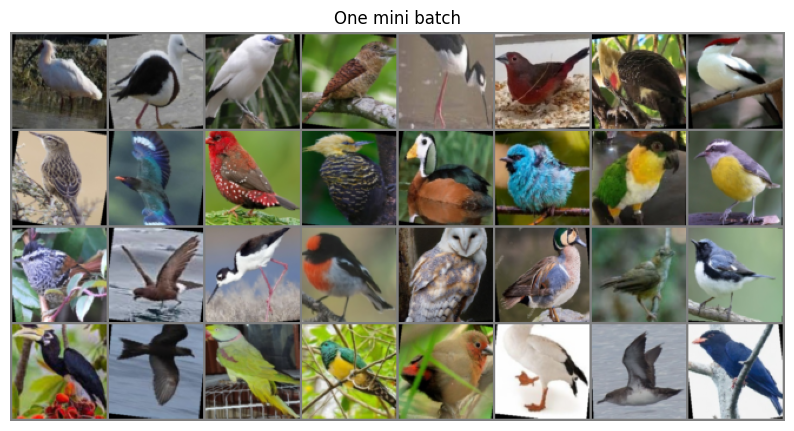

In [43]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [44]:
class ConvNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(18496, 1600)
        self.fc2 = nn.Linear(1600, 512)
        self.fc3 = nn.Linear(512, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=18496, out_features=1600, bias=True)
  (fc2): Linear(in_features=1600, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=100, bias=True)
)

In [45]:
from torchsummary import summary
summary(model, (3, 80, 80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 76, 76]           2,432
         MaxPool2d-2           [-1, 32, 38, 38]               0
            Conv2d-3           [-1, 64, 34, 34]          51,264
         MaxPool2d-4           [-1, 64, 17, 17]               0
           Flatten-5                [-1, 18496]               0
            Linear-6                 [-1, 1600]      29,595,200
            Linear-7                  [-1, 512]         819,712
            Linear-8                  [-1, 100]          51,300
Total params: 30,519,908
Trainable params: 30,519,908
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.07
Forward/backward pass size (MB): 2.63
Params size (MB): 116.42
Estimated Total Size (MB): 119.12
----------------------------------------------------------------


In [47]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [48]:
train_losses, train_accs = [], []
def train_loop(dataloader, model, loss_fn, optimizer, device):
    train_loss, train_acc, total = 0, 0, 0
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        total += X.shape[0]
        preds = model(X)
        loss = loss_fn(preds, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        _, pred_cls = torch.max(preds.data, dim=1)
        train_acc += (pred_cls == y).sum().item()
        train_loss += loss.item()

    tr_loss = train_loss / len(dataloader.dataset)
    train_losses.append(tr_loss)
    train_accs.append(train_acc / total)

In [49]:
test_losses, test_accs = [], []
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        num_same = 0
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()

            if len(outputs.shape) == 1:
                preds = outputs > 0
                num_same += sum(preds == y).item()
            else:
                _, indices = torch.max(outputs, 1)
                num_same += sum(indices == y).item()
        print(f'Average loss: {total_loss / len(dataloader.dataset)}')
        test_losses.append(total_loss / len(dataloader.dataset))
        print(f'Accuracy: {num_same / len(dataloader.dataset)}')
        test_accs.append(num_same / len(dataloader.dataset))

In [50]:
for epoch in range(10):
     train_loop(trainloader, model, loss_fn, optimizer, device)
     test_loop(testloader, model, loss_fn, device)

Average loss: 0.13211749839782716
Accuracy: 0.168
Average loss: 0.09340506887435913
Accuracy: 0.32
Average loss: 0.10579317617416382
Accuracy: 0.378
Average loss: 0.09038523030281066
Accuracy: 0.48
Average loss: 0.08934893298149109
Accuracy: 0.536
Average loss: 0.07199175083637238
Accuracy: 0.584
Average loss: 0.092569819688797
Accuracy: 0.556
Average loss: 0.08796060156822205
Accuracy: 0.582
Average loss: 0.09152399110794067
Accuracy: 0.598
Average loss: 0.0760469069480896
Accuracy: 0.658


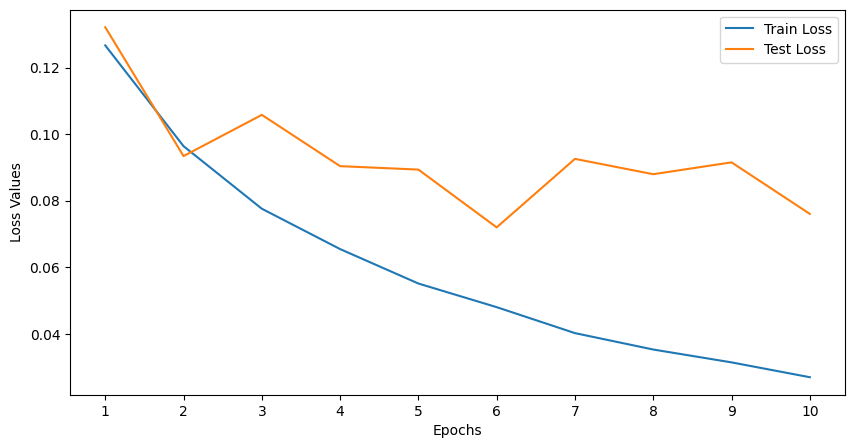

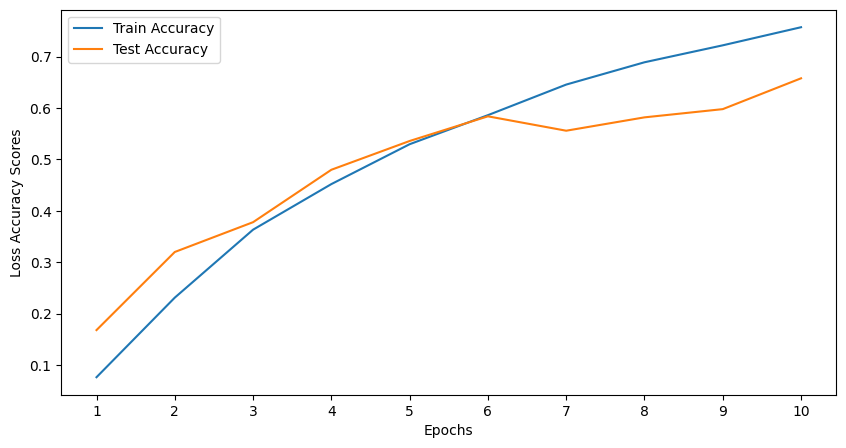

In [51]:
def learning_curves(tr_losses, test_losses, tr_accs, test_accs):

    plt.figure(figsize = (10, 5))
    plt.plot(train_losses, label = "Train Loss")
    plt.plot(test_losses, label = "Test Loss")
    plt.xlabel("Epochs"); plt.ylabel("Loss Values")
    plt.xticks(ticks = np.arange(len(tr_losses)), labels = [i for i in range(1, len(tr_losses) + 1)])
    plt.legend(); plt.show()

    plt.figure(figsize = (10, 5))
    plt.plot(train_accs, label = "Train Accuracy")
    plt.plot(test_accs, label = "Test Accuracy")
    plt.xlabel("Epochs"); plt.ylabel("Loss Accuracy Scores")
    plt.xticks(ticks = np.arange(len(tr_accs)), labels = [i for i in range(1, len(tr_accs) + 1)])
    plt.legend(); plt.show()

learning_curves(tr_losses=train_losses, test_losses=test_losses, tr_accs=train_accs, test_accs=test_accs)

In [52]:
def imshowaxis(ax, img, orig, pred):
    img = img / 2 + 0.5
    npimg = img.numpy()
    npimg = np.clip(npimg, 0, 1)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    if orig != pred:
        ax.set_title(orig + "\n" + pred, color="red")
    else:
        ax.set_title(orig + "\n" + pred)
    ax.axis("off")


def vis_model(model, num_images=25):
    was_training = model.training
    model.eval()
    images_so_far = 0
    figure, ax = plt.subplots(5, 5, figsize=(20, 20))


    with torch.no_grad():
        for i , (inputs, labels) in enumerate(dataloaders["test"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(5):
                for j in range(5):
                    if images_so_far < num_images:
                        imshowaxis(ax[i][j], inputs.cpu().data[images_so_far], CLASSES[labels[images_so_far]], CLASSES[preds[images_so_far]])
                    else:
                        model.train(mode=was_training)
                        return
                    images_so_far += 1
        model.train(mode=was_training)

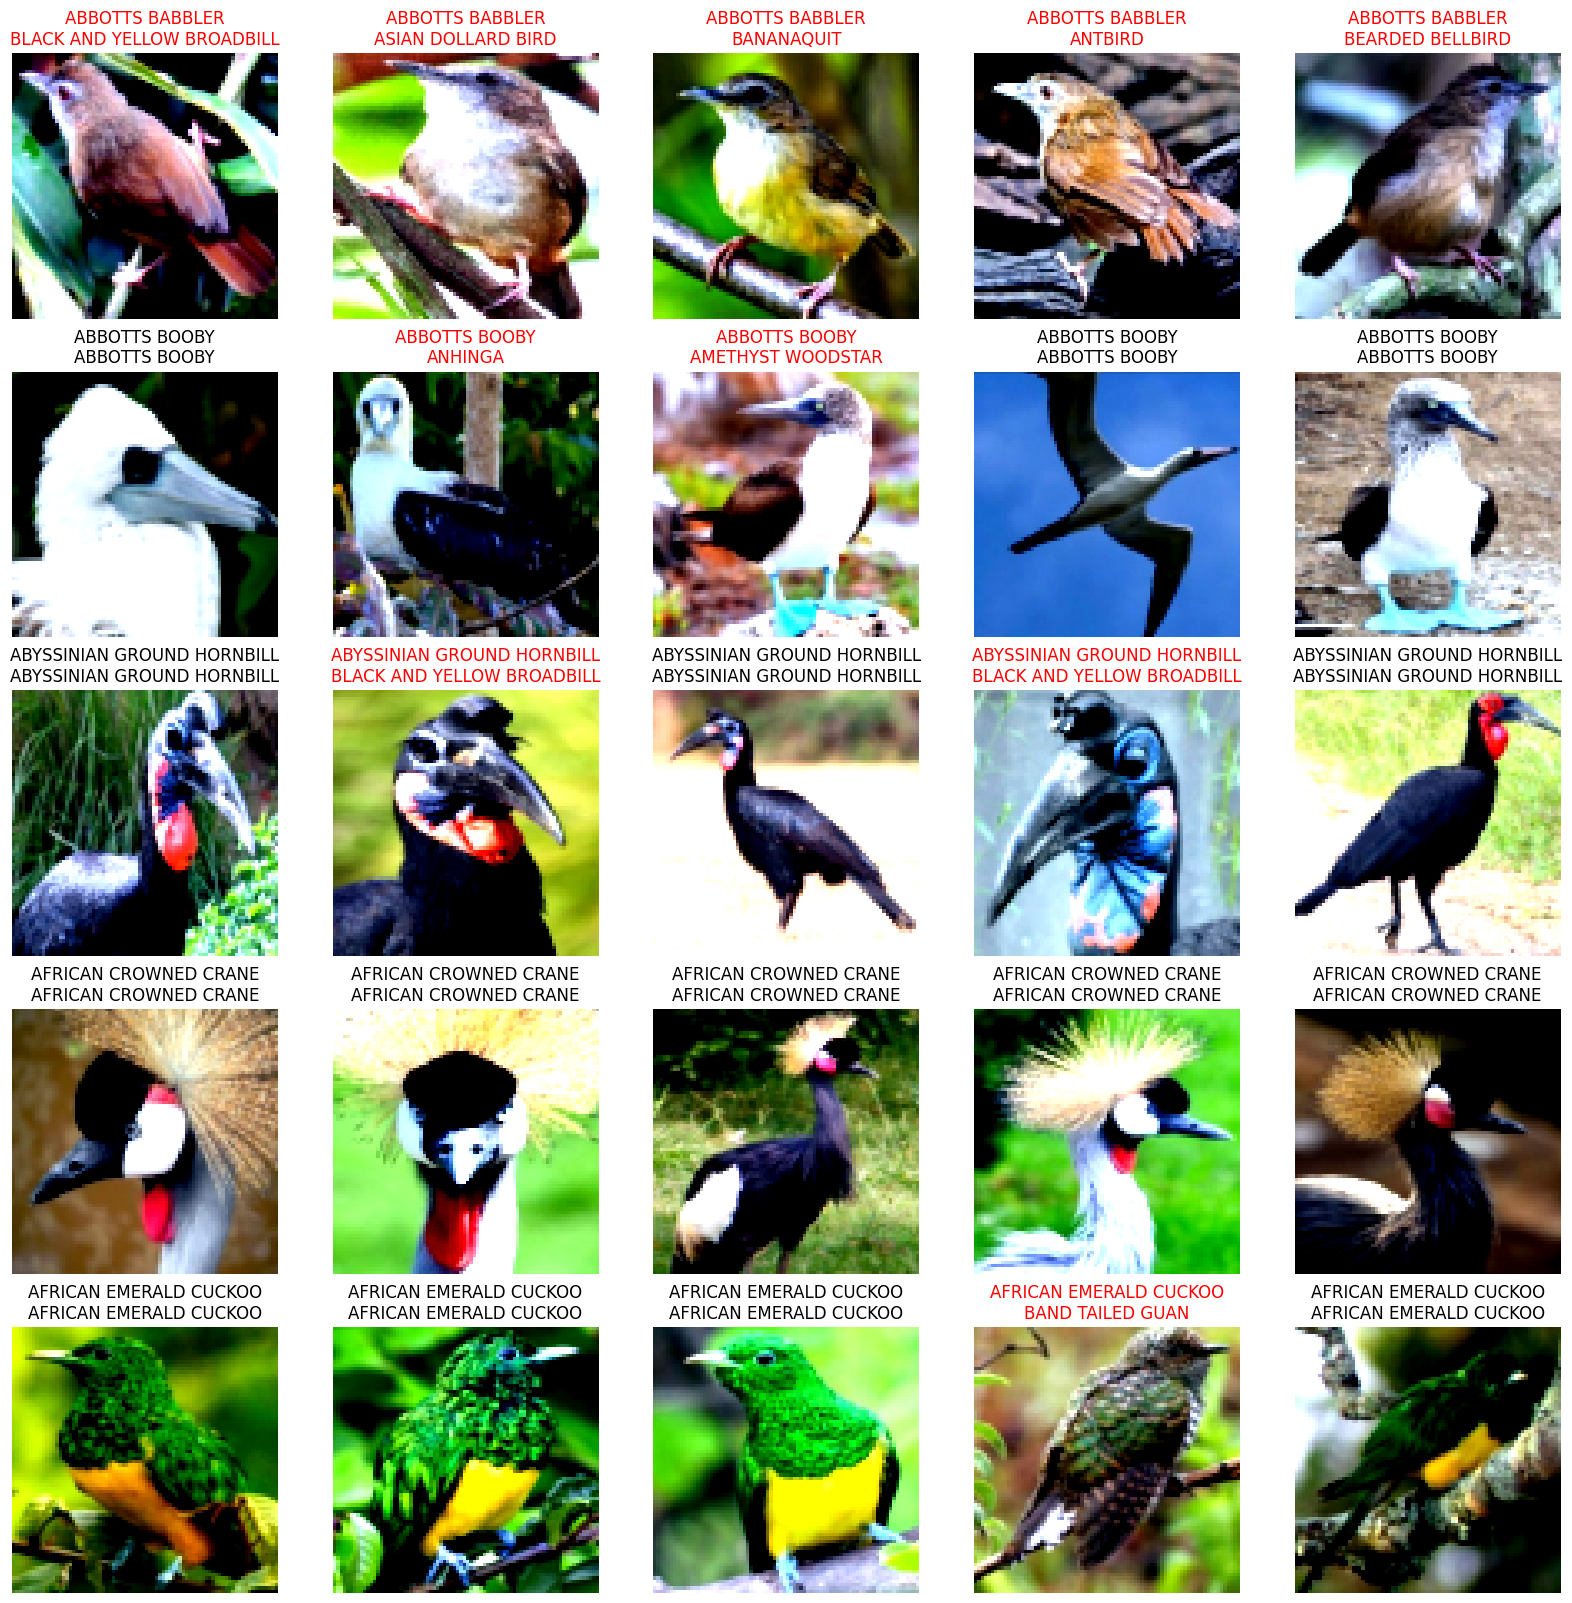

In [53]:
vis_model(model)